<a href="https://colab.research.google.com/github/Andarsan/time_row/blob/main/github_time_row.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, \
                             RandomizedSearchCV, TimeSeriesSplit, cross_val_score

from sklearn.linear_model import LinearRegression
# модели
! pip install catboost
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception as ex:
    template = "An exception of type {0} occurred. Arguments:\n{1!r}"
    message = template.format(type(ex).__name__, ex.args)
    print(message)
import os
import time
import copy

Defaulting to user installation because normal site-packages is not writeable
An exception of type ModuleNotFoundError occurred. Arguments:
("No module named 'google.colab'",)


In [ ]:
pth1 = '/datasets'#/ferma_main.csv'
pth2 = '/content/drive/MyDrive/Colab Notebooks/all_project'#/ferma_main.csv'
pth3 = 'C:/Users/andar/Downloads'
if os.path.exists(pth1):
  pth = pth1
elif os.path.exists(pth2):
  pth = pth2
elif os.path.exists(pth3):
  pth = pth3
else:
  pth = 'Something is wrong'
display(f'рабочий каталог: {pth}')

'рабочий каталог: C:/Users/andar/Downloads'

In [ ]:

def df_plt_describe(_df,_for,describe=False):
    for i in _for:
        j=0
        for _ in range(1):
            if _df[i].dtype != 'object':
                # Set up the plot
                ax = plt.subplot(2, 2, j + 1)
                j = j+1
                # Draw the plot
                ax.boxplot(_df[i])
                # Title and labels
                ax.set_title(i)
                ax = plt.subplot(2, 2, j + 1)
                j = j+1
                # Draw the plot
                ax.hist(_df[i])
                # Title and labels
                ax.set_title(i)
        plt.tight_layout()
        plt.show()
        plt.close()
    if describe:
        display(_df[_for].describe())


In [ ]:
df = pd.read_csv(pth + '/taxi.csv', index_col=[0], parse_dates=[0])
display(df.head(5))
display(df.info())


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

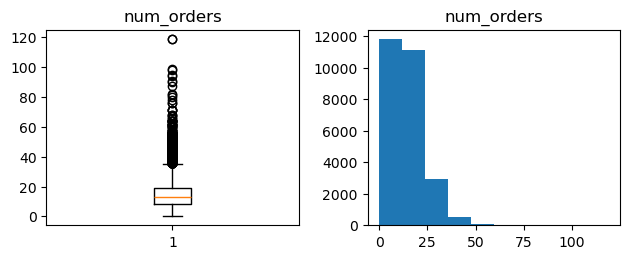

In [ ]:
df_plt_describe(df,['num_orders'])

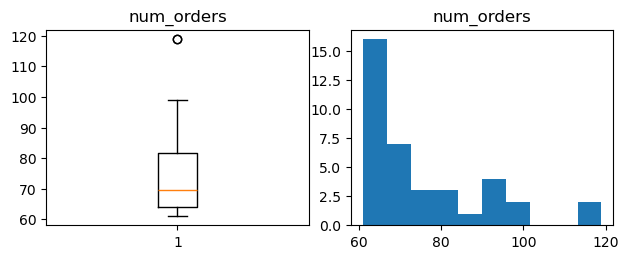

In [ ]:
df_plt_describe(df.query('num_orders > 60'),['num_orders'])

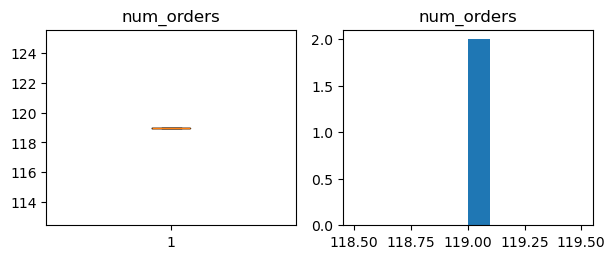

In [ ]:
df_plt_describe(df.query('num_orders > 100'),['num_orders'])

•	Всё по красоте

In [ ]:
df = df.sort_index()

In [ ]:
df['resample_sum'] = df.resample('1h').sum()
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['minute'] = df.index.minute
df['second'] = df.index.second

В итоге:
* прочитали данные и обозначили индекс datatime
* создали распределения по одному часу.
* добавили новые признаки из индекса год, месяц, ниделя, день, час, минута, секунда, ресемпл по часу (наш целевой п.)

## Анализ

In [ ]:
for _i in ['year','month','day','hour','minute','second']:
    display(df[_i].unique())

array([2018])

array([3, 4, 5, 6, 7, 8])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

array([ 0, 10, 20, 30, 40, 50])

array([0])

* секунд не существует удалим их
* год один тоже не нужен
* минуты и вызовы по минутам нам тоже не нужны

In [ ]:
df = df.drop(columns=['year','second','num_orders','minute'])

In [ ]:
_n = []

for i in range(0,df.shape[0]-1):
    _n.append(df.index.values[i+1] == df.index.values[i] + 600000000000 )

display(df.shape[0]-1,sum(_n))

26495

26495

* спустился по временным индексам прибавляя по 10 минут.
* идёт ли временный ряд последовательно +10 минут
* всё чётка не одного сбоя!
* удалим все nan

In [ ]:
df = df.dropna()

<Axes: xlabel='datetime'>

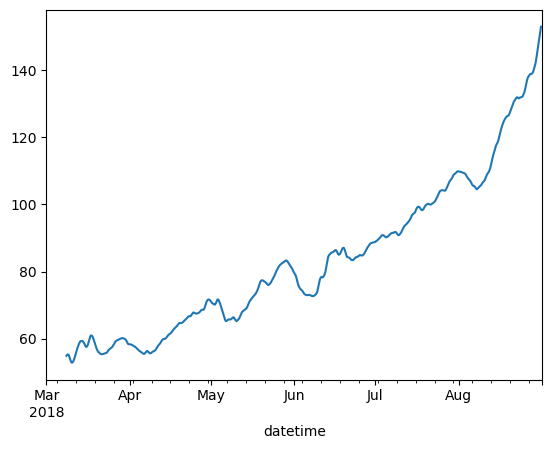

In [ ]:
decompos = seasonal_decompose(df['resample_sum'])
decompos.trend.rolling(24*7).mean().plot()

<Axes: xlabel='datetime'>

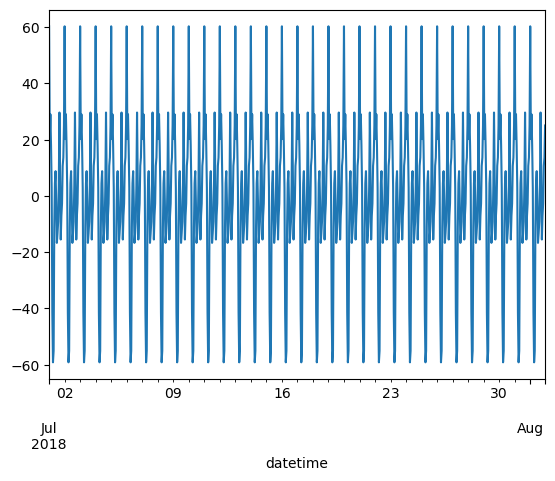

In [ ]:
decompos.seasonal['2018-07-01':'2018-08-01'].plot()

<Axes: xlabel='datetime'>

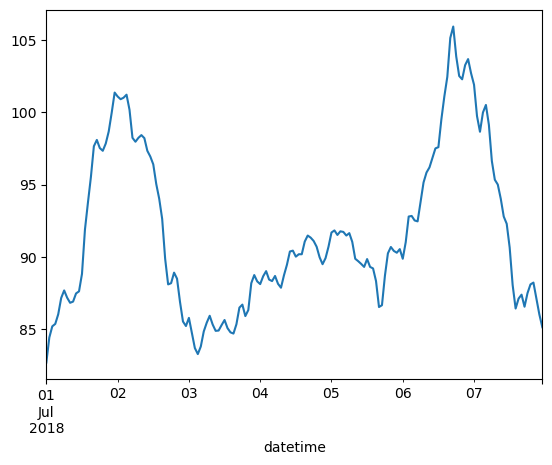

In [ ]:
decompos.trend['2018-07-01':'2018-07-07'].plot()

<Axes: xlabel='datetime'>

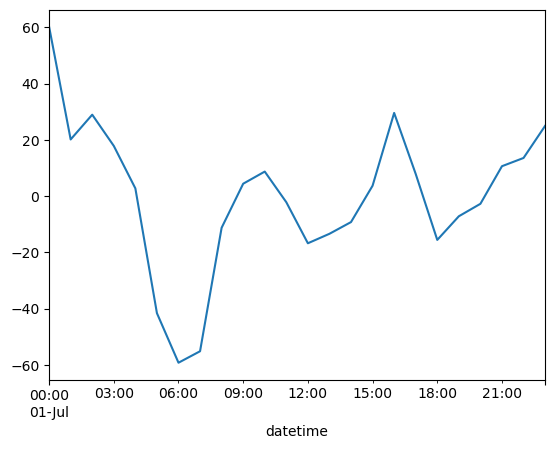

In [ ]:
decompos.seasonal['2018-07-01':'2018-07-01'].plot()

Вывод:
* временной ряд не нарушен.
* наблюдается равномерный рост количества заказов (это либо сезонно либо рост бизнеса)
* наблюдается  два пика заказа в неделю
* и в течении суток меняется число заказов


## Обучение

In [ ]:
_df = df.copy()
def make_features(data, max_lag, rolling_mean_size):
    _df['month'] = data.index.month
    _df['day'] = data.index.day
    _df['hour'] = data.index.hour
    _df['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['resample_sum'].shift(lag)
    data['resample_mean'] = data['resample_sum'].shift().rolling(rolling_mean_size).mean()

make_features(_df,12,1)
_df=_df.dropna()

In [ ]:
_df

,resample_sum,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,resample_mean
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 12:00:00,30.0,3,1,12,3,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,96.0
2018-03-01 13:00:00,32.0,3,1,13,3,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,30.0
2018-03-01 14:00:00,48.0,3,1,14,3,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,32.0
2018-03-01 15:00:00,66.0,3,1,15,3,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,48.0
2018-03-01 16:00:00,43.0,3,1,16,3,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136.0,8,31,19,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,207.0
2018-08-31 20:00:00,154.0,8,31,20,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,136.0
2018-08-31 21:00:00,159.0,8,31,21,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,154.0


In [ ]:
train, test = train_test_split(_df, shuffle=False, test_size=0.1)


x_train = train.drop(columns='resample_sum')
y_train = train['resample_sum']

x_test = test.drop(columns='resample_sum')
y_test = test['resample_sum']



In [ ]:
def def_RandomizedSearchCV(model_name,param_grid):
    randomized_search = RandomizedSearchCV(
        model_name,
        param_grid,
        cv=TimeSeriesSplit(n_splits=5),
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    # фиксируем время старта работы кода
    start = time.time()
    randomized_search.fit(x_train, y_train)
    best_rmse = abs(round(randomized_search.best_score_, 1))
    display(f'модель                           : {randomized_search.best_estimator_}')
    display(f'параметры                        : {randomized_search.best_params_}')
    display(f'время работы  RandomizedSearchCV : {str(time.time() - start)}')
    display(f'RMSE                             : {best_rmse}')

    # фиксируем время старта работы кода
    start = time.time()
    randomized_search.best_estimator_.fit(x_train, y_train)
    display(f'время обучения fit               : {str(time.time() - start)}')
    # фиксируем время старта работы кода
    start = time.time()
    y_pred = randomized_search.best_estimator_.predict(x_train)
    display(f'RMSE predict на тренеровочных    : {mean_squared_error(y_train, y_pred,squared=False)}')
    display(f'время предсказания               : {str(time.time() - start)}')

In [ ]:
param_grid = {'max_depth': range(2,24),
        'max_features': range(2,24),
        'min_samples_split': range(2,24),
        'min_samples_leaf': range(2,24)}

model_name = DecisionTreeRegressor(random_state=12345)

def_RandomizedSearchCV(model_name,param_grid)

'модель                           : DecisionTreeRegressor(max_depth=15, max_features=21, min_samples_leaf=10,\n                      min_samples_split=14, random_state=12345)'

"параметры                        : {'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': 21, 'max_depth': 15}"

'время работы  RandomizedSearchCV : 0.10514259338378906'

'RMSE                             : 29.2'

'время обучения fit               : 0.02093362808227539'

'RMSE predict на тренеровочных    : 18.499361533416018'

'время предсказания               : 0.0013349056243896484'

In [ ]:
param_grid = {'n_jobs': [1, -1]}

model_name = LinearRegression()

def_RandomizedSearchCV(model_name,param_grid)

'модель                           : LinearRegression(n_jobs=1)'

"параметры                        : {'n_jobs': 1}"

'время работы  RandomizedSearchCV : 0.030370235443115234'

'RMSE                             : 31.4'

'время обучения fit               : 0.002159595489501953'

'RMSE predict на тренеровочных    : 30.087249733780148'

'время предсказания               : 0.002000093460083008'

In [ ]:
param_grid = {'boosting_type': ['gbdt'],'num_leaves':[15,20]}

model_name = LGBMRegressor(random_state=12345)

def_RandomizedSearchCV(model_name,param_grid)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2540
[LightGBM] [Info] Number of data points in the train set: 3963, number of used features: 17
[LightGBM] [Info] Start training from score 78.360838


'модель                           : LGBMRegressor(num_leaves=15, random_state=12345)'

"параметры                        : {'num_leaves': 15, 'boosting_type': 'gbdt'}"

'время работы  RandomizedSearchCV : 3.99893856048584'

'RMSE                             : 24.9'

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2540
[LightGBM] [Info] Number of data points in the train set: 3963, number of used features: 17
[LightGBM] [Info] Start training from score 78.360838


'время обучения fit               : 0.03072500228881836'

'RMSE predict на тренеровочных    : 17.0548763070377'

'время предсказания               : 0.003013134002685547'

In [ ]:
param_grid = {'grow_policy': ['Lossguide'],'depth': [10]}

model_name = CatBoostRegressor(random_state=12345, verbose=False)

def_RandomizedSearchCV(model_name,param_grid)


'модель                           : <catboost.core.CatBoostRegressor object at 0x000001B654207550>'

"параметры                        : {'grow_policy': 'Lossguide', 'depth': 10}"

'время работы  RandomizedSearchCV : 8.085861921310425'

'RMSE                             : 24.9'

'время обучения fit               : 3.1361536979675293'

'RMSE predict на тренеровочных    : 6.320551872037783'

'время предсказания               : 0.009739398956298828'

## Тестирование

In [ ]:
# фиксируем время старта работы кода
start = time.time()
model = CatBoostRegressor(random_state=12345, verbose=False, grow_policy = 'Lossguide', depth = 10)
model.fit(x_train,y_train)
display(f'время работы fit     : ' + str(time.time() - start))
# фиксируем время старта работы кода
start = time.time()
#str_cross_val_score = cross_val_score(model,
#                x_test,
#                y_test,
#                cv=TimeSeriesSplit(n_splits=5),
#                scoring = "neg_root_mean_squared_error").mean()*-1

y_pred = model.predict(x_test)
display(f'Время работы predict : {str(time.time() - start)}')
display(f'SMAPE                : {mean_squared_error(y_test, y_pred, squared=False)}')

'время работы fit     : 3.1242287158966064'

'Время работы predict : 0.0050008296966552734'

'SMAPE                : 42.82752712502176'

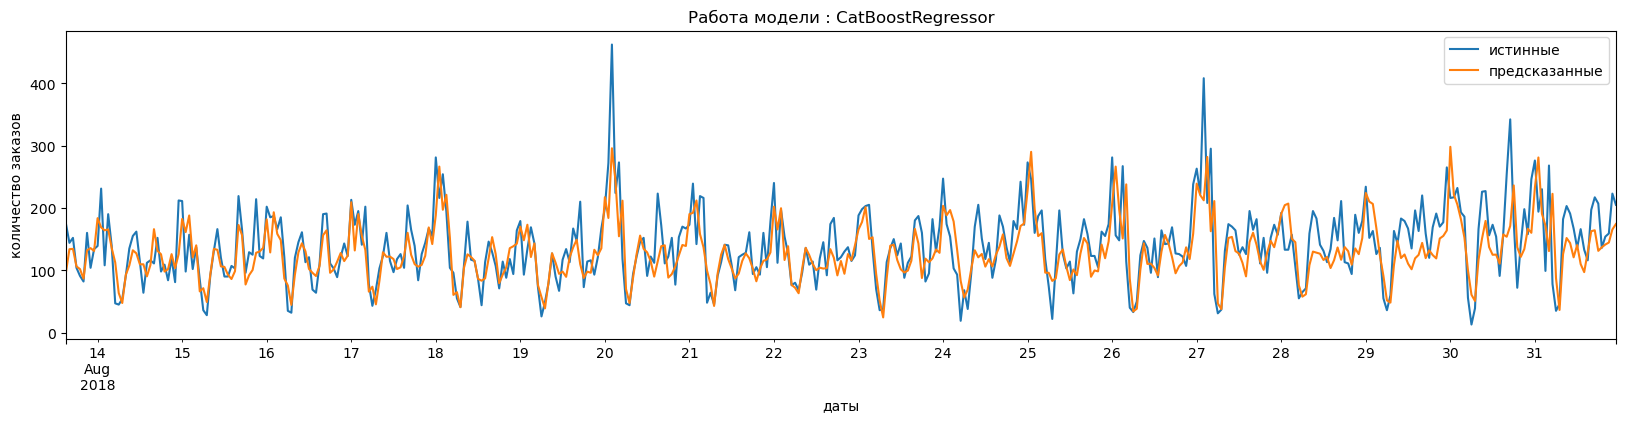

In [ ]:
result = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
result.plot(title='Работа модели : CatBoostRegressor',figsize=(20, 4))
plt.xlabel( 'даты')
plt.ylabel('количество заказов')
plt.legend(['истинные', 'предсказанные'])
plt.show()


**Вывод:**

* Здесь представлено решение  по создании модели МО для прогнозирования количества заказов такси на следующий час.
* Было использован набор данных за неполный год осень и лето 2018 года
* В данной задачи модель CatBoostRegressor   показала себя наилучшим образом.


In [ ]:
'end'

'end'